# Custom spatial static time series

In this notebook, we create *static time series* regarding the spatial position for the administrative regions of each country and the waterways (HOTOSM Waterways (OpenStreetMap Export)).

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.ops import cascaded_union
import pandas as pd
import numpy as np

In [2]:
# Set default setting for the figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 12) # fontsize of the x and y labels
plt.rc("axes", titlesize = 12) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 12) # legend fontsize

In [3]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP

In [4]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [5]:
# Load the adminstrative shapefiles of each country.
COUNTRIES = ["Syria", "Yemen", "Burkina Faso", "Nigeria", "Niger", "Mali", "Cameroon"]

path = "../../packages/MapPlot/shapefiles/"
dfs = []

for country in COUNTRIES:
    df_admin = gpd.read_file(f"{path}/adminstratas/{country}/{country}.shp")
    df_admin.rename(columns = {"region": "AdminStrata", "country": "Country"}, inplace = True)
    dfs.append(df_admin)

In [6]:
# Concatenate data.
df_admin = pd.concat(dfs, axis = 0, ignore_index = True)
df_admin.head()

,AdminStrata,Country,geometry
0,Al-Hasakeh,Syria,"POLYGON ((42.22692 37.27664, 42.22710 37.27661..."
1,Aleppo,Syria,"POLYGON ((38.29637 36.90689, 38.31160 36.90575..."
2,Ar-Raqqa,Syria,"POLYGON ((38.79528 36.69788, 38.80076 36.69744..."
3,As-Sweida,Syria,"POLYGON ((36.88491 33.05645, 36.89817 33.05393..."
4,Damascus,Syria,"POLYGON ((36.32519 33.56409, 36.32534 33.56412..."


In [7]:
# Load the natural water shapefiles of each country.
COUNTRIES = ["Syria", "Yemen", "Burkina Faso", "Nigeria", "Niger", "Mali", "Cameroon"]

path = "../../packages/MapPlot/shapefiles/"
dfs = []

for country in COUNTRIES:
    df_waterways = gpd.read_file(f"{path}/waterways/{country}/{country}.shp")
    df_waterways["Country"] = country
    df_waterways = df_waterways[df_waterways["waterway"].isin(["river"])]
    dfs.append(df_waterways[["Country", "geometry"]])

In [8]:
# Concatenate data.
df_water = pd.concat(dfs, axis = 0, ignore_index = True)
df_water.head()

,Country,geometry
0,Syria,"LINESTRING (36.37229 35.89382, 36.37239 35.893..."
1,Syria,"LINESTRING (36.60867 36.33564, 36.60822 36.335..."
2,Syria,"LINESTRING (40.20429 36.81583, 40.20337 36.815..."
3,Syria,"LINESTRING (40.15527 36.72352, 40.15536 36.723..."
4,Syria,"LINESTRING (40.23351 36.91128, 40.23430 36.910..."


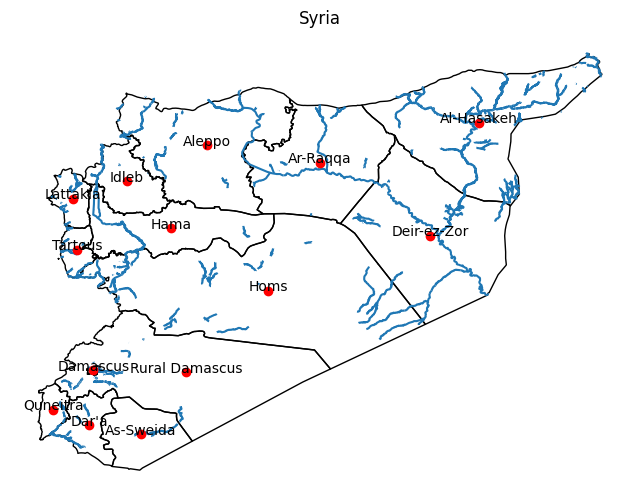

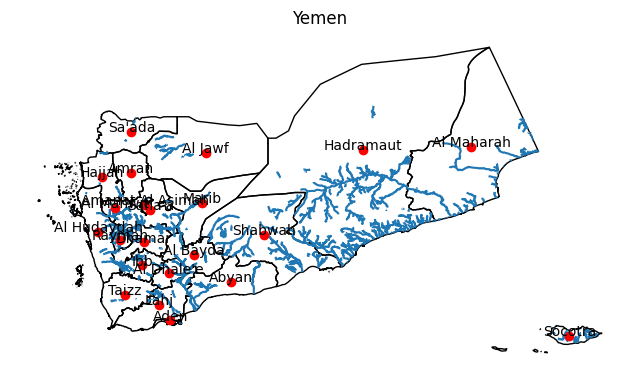

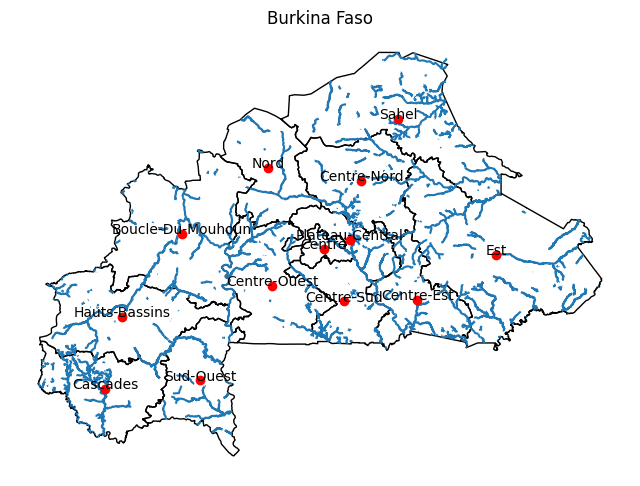

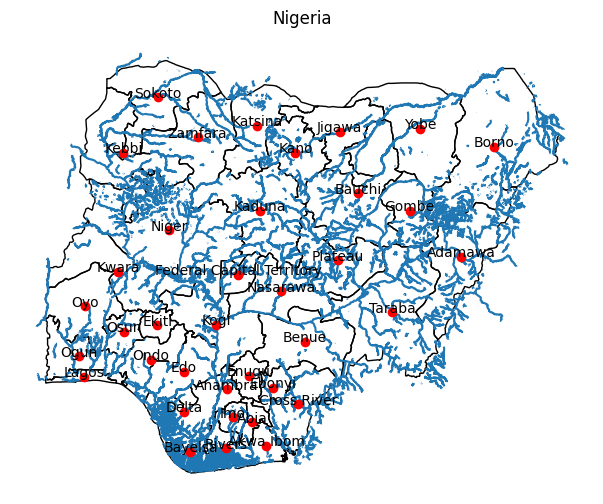

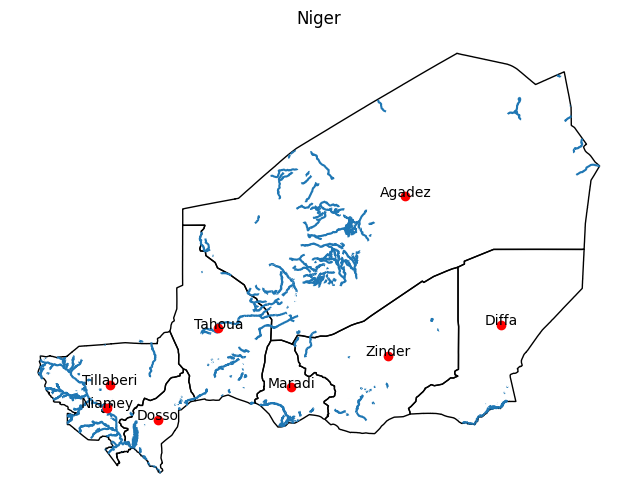

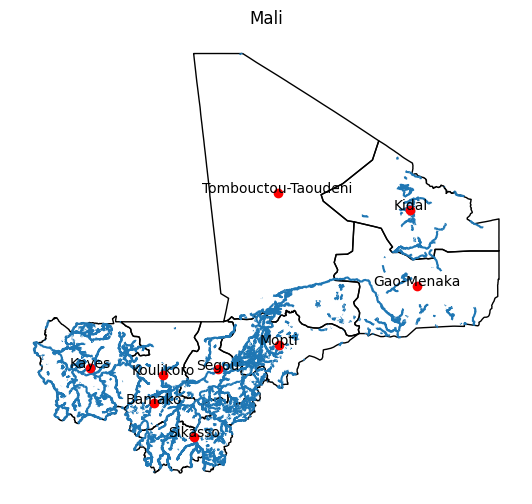

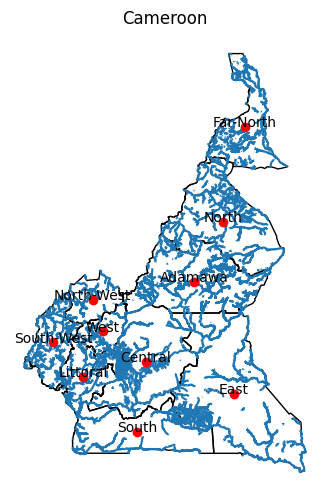

In [9]:
for country in COUNTRIES:
    fig, ax = plt.subplots(figsize = (8,6)) 
    subdf_admin = df_admin[df_admin["Country"] == country]
    
    subdf_admin.plot(ax = ax, edgecolor = "black", facecolor = "none")
    df_water[df_water["Country"] == country]["geometry"].plot(ax = ax)
    
    for x, y, label in zip(subdf_admin.centroid.x, subdf_admin.centroid.y, subdf_admin["AdminStrata"]):
        ax.text(x, y, label, ha = "center", size = 10)
        ax.plot(x, y, "o", c = "red")
        
    ax.set_title(country)
    
    plt.axis("off")
    
    fig.savefig(PATH_TO_SAVE_DATA + f"{country}.png", dpi = 300, bbox_inches = "tight")

In [10]:
# Union objects.
df_water = df_water.groupby("Country", as_index = False).agg(water = ("geometry", lambda x: cascaded_union(x.geometry)))

In [11]:
df = pd.merge(df_admin, df_water, on = "Country")

In [12]:
# Compute some spatial features.
df["Area"] = df["geometry"].area
df["Lon"] = df["geometry"].centroid.x
df["Lat"] = df["geometry"].centroid.y

In [13]:
df["Waterways"] = df.apply(lambda x: x["geometry"].intersection(x["water"]).length, axis = 1)
df.drop(["geometry", "water"], axis = 1, inplace = True)
df.head()

,AdminStrata,Country,Area,Lon,Lat,Waterways
0,Al-Hasakeh,Syria,2.330266,40.907354,36.491475,14.706878
1,Aleppo,Syria,1.993687,37.642710,36.218085,4.417552
2,Ar-Raqqa,Syria,1.762222,38.994679,36.011530,4.352764
3,As-Sweida,Syria,0.611739,36.846754,32.748570,0.771683
4,Damascus,Syria,0.011323,36.278080,33.515687,0.374298


In [14]:
# Create multi-index columns dataframe.
df = df.set_index(["Country", "AdminStrata"]).T.unstack().to_frame().T.sort_index(axis = 1, level = [0, 1, 2])
df.columns.set_names("Indicator", level = 2, inplace = True)
df

Country          Burkina Faso                                          \
AdminStrata Boucle-Du-Mouhoun                                Cascades   
Indicator                Area        Lat       Lon Waterways     Area   
0                    2.866733  12.535927 -3.488905  9.290487  1.50947   

Country                                                           ...  \
AdminStrata                                    Centre             ...   
Indicator          Lat       Lon  Waterways      Area        Lat  ...   
0            10.354484 -4.570349  10.768789  0.248302  12.325874  ...   

Country          Yemen                                                       \
AdminStrata    Shabwah              Socotra                                   
Indicator          Lon  Waterways      Area        Lat        Lon Waterways   
0            46.923133  17.739564  0.324891  12.488974  53.805239  3.155227   

Country                                              
AdminStrata   Taizz                                  
Indicator      Area        Lat        Lon Waterways  
0            0.8409  13.416517  43.778161  0.852916  

[1 rows x 452 columns]

In [15]:
# Define reference dates to build the time series.
FIRST_YEAR = "2018"
LAST_YEAR = "2023"

new_index = pd.date_range(FIRST_YEAR, LAST_YEAR, freq = "D")

In [16]:
# Create static time series of the coordinates.
df = df.loc[df.index.repeat(len(new_index))]
df.index = new_index
df.index.name = "Datetime"
df.head()

Country          Burkina Faso                                          \
AdminStrata Boucle-Du-Mouhoun                                Cascades   
Indicator                Area        Lat       Lon Waterways     Area   
Datetime                                                                
2018-01-01           2.866733  12.535927 -3.488905  9.290487  1.50947   
2018-01-02           2.866733  12.535927 -3.488905  9.290487  1.50947   
2018-01-03           2.866733  12.535927 -3.488905  9.290487  1.50947   
2018-01-04           2.866733  12.535927 -3.488905  9.290487  1.50947   
2018-01-05           2.866733  12.535927 -3.488905  9.290487  1.50947   

Country                                                           ...  \
AdminStrata                                    Centre             ...   
Indicator          Lat       Lon  Waterways      Area        Lat  ...   
Datetime                                                          ...   
2018-01-01   10.354484 -4.570349  10.768789  0.248302  12.325874  ...   
2018-01-02   10.354484 -4.570349  10.768789  0.248302  12.325874  ...   
2018-01-03   10.354484 -4.570349  10.768789  0.248302  12.325874  ...   
2018-01-04   10.354484 -4.570349  10.768789  0.248302  12.325874  ...   
2018-01-05   10.354484 -4.570349  10.768789  0.248302  12.325874  ...   

Country          Yemen                                                       \
AdminStrata    Shabwah              Socotra                                   
Indicator          Lon  Waterways      Area        Lat        Lon Waterways   
Datetime                                                                      
2018-01-01   46.923133  17.739564  0.324891  12.488974  53.805239  3.155227   
2018-01-02   46.923133  17.739564  0.324891  12.488974  53.805239  3.155227   
2018-01-03   46.923133  17.739564  0.324891  12.488974  53.805239  3.155227   
2018-01-04   46.923133  17.739564  0.324891  12.488974  53.805239  3.155227   
2018-01-05   46.923133  17.739564  0.324891  12.488974  53.805239  3.155227   

Country                                              
AdminStrata   Taizz                                  
Indicator      Area        Lat        Lon Waterways  
Datetime                                             
2018-01-01   0.8409  13.416517  43.778161  0.852916  
2018-01-02   0.8409  13.416517  43.778161  0.852916  
2018-01-03   0.8409  13.416517  43.778161  0.852916  
2018-01-04   0.8409  13.416517  43.778161  0.852916  
2018-01-05   0.8409  13.416517  43.778161  0.852916  

[5 rows x 452 columns]

In [17]:
# Now save the time series of each country keeping as indeces for each time series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [18]:
# Save the static time series.
df.groupby(level = "Country", axis = 1).apply(lambda x: save(x, name = "wfp_geospatial"));

In [19]:
# Plot static time series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Geospatial data")

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()